In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cad_df = pd.read_csv('final_data.csv')
cad_df['Cath'].value_counts()

,count
Cath,
0,216
1,87


# ***Forward Selection***

In [ ]:
#Separate features and target columns
X_feature = cad_df.drop('Cath', axis=1)
y_target = cad_df['Cath']

rf_model = RandomForestClassifier(random_state=1)
forward_selector = SequentialFeatureSelector(estimator=rf_model, k_features=30, forward=True, floating=False,scoring='accuracy', cv=2)
select_fit = forward_selector.fit(X_feature, y_target)
selected_features = X_feature.columns[list(select_fit.k_feature_idx_)]
X_forward = X_feature[selected_features]

print('Selected features with Forward selection: ', selected_features)
print("\nDataframe with only the selected features:")
print(X_forward.head(5))

Selected features with Forward selection:  Index(['Age', 'Sex', 'BMI', 'DM', 'HTN', 'Current Smoker', 'FH', 'CRF',
       'Airway disease', 'Thyroid Disease', 'CHF', 'DLP', 'Edema',
       'Weak Peripheral Pulse', 'Typical Chest Pain', 'Dyspnea',
       'Function Class', 'Atypical', 'LowTH Ang', 'Q Wave', 'St Depression',
       'Tinversion', 'LVH', 'Poor R Progression', 'FBS', 'HDL', 'WBC', 'Lymph',
       'EF-TTE', 'Region RWMA'],
      dtype='object')

Dataframe with only the selected features:
   Age  Sex        BMI  DM  HTN  Current Smoker  FH  CRF  Airway disease  \
0   53    1  29.387755   0    1               1   0    0               0   
1   67    0  28.398718   0    1               0   0    0               0   
2   54    1  20.077335   0    0               1   0    0               0   
3   66    0  26.838648   0    1               0   0    0               0   
4   50    0  37.165193   0    1               0   0    0               0   

   Thyroid Disease  ...  St Depression  

# ***Data splitting***

In [ ]:
# 80% data for training and 20% data for testing
X_train, X_test, y_train, y_test = train_test_split(X_forward, y_target, test_size=0.2, random_state=1)

print(f"The training set contains {X_train.shape[0]} patient records and {X_train.shape[1]} features.")
print(f"The test set contains {X_test.shape[0]} patient records, each with {X_test.shape[1]} features.")

The training set contains 242 patient records and 30 features.
The test set contains 61 patient records, each with 30 features.


# ***SMOTENC***

In [ ]:
categorical_cols = [col for col in X_train.columns if X_train[col].nunique() <= 4]
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=1)
X_balanced, y_balanced = smote_nc.fit_resample(X_train, y_train)

print("Imbalanced distribution:", Counter(y_train))
print("Balanced distribution:", Counter(y_balanced))

Imbalanced distribution: Counter({0: 170, 1: 72})
Balanced distribution: Counter({0: 170, 1: 170})


Applied SMOTENC balancing only to the testing set

In [ ]:
X_balanced

,Age,Sex,BMI,DM,HTN,Current Smoker,FH,CRF,Airway disease,Thyroid Disease,...,St Depression,Tinversion,LVH,Poor R Progression,FBS,HDL,WBC,Lymph,EF-TTE,Region RWMA
0,41,1,35.832661,1,1,0,1,0,0,0,...,0,0,0,0,125,45.000000,6900,41,55,0
1,79,1,24.609375,0,0,0,0,0,0,0,...,0,1,0,0,75,44.000000,7200,36,40,1
2,81,0,27.180900,0,1,0,0,0,0,0,...,0,0,1,0,94,43.000000,6000,37,45,0
3,56,0,26.142688,0,0,0,0,0,0,0,...,0,1,0,0,151,45.000000,5700,37,45,0
4,60,1,22.675737,0,0,0,0,0,1,0,...,0,0,0,0,84,55.000000,4100,42,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,50,0,28.418275,0,1,0,0,0,0,0,...,0,0,0,0,86,36.406512,5651,36,38,0
336,48,0,31.598125,0,1,0,0,0,0,0,...,0,0,0,0,85,53.720170,6669,33,49,0
337,50,1,30.796815,0,0,0,0,0,0,0,...,0,0,0,0,117,43.444431,7507,35,35,0
338,45,1,23.932806,0,0,0,0,0,0,0,...,0,0,0,0,83,43.744495,8462,49,54,0


# ***Random Forest Classifier (RF)***

In [ ]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 8],
                'max_features': ['sqrt', 'log2']}

RF_mdl = RandomForestClassifier()
RF_randomcv = RandomizedSearchCV(RF_mdl, param_random, n_iter=20, cv=5)
RF_randomcv.fit(X_balanced, y_balanced)
RF_param = RF_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(RF_randomcv.best_score_))
print("Optimal parameters of RF classifier: ", RF_param)

#Training RF model with optimal parameters
RF_best_mdl = RandomForestClassifier(**RF_param)
RF_best_mdl.fit(X_balanced, y_balanced)

# Training performance
train_pred = RF_best_mdl.predict(X_balanced)
training_acc = RF_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of RF classifier: {training_acc:.4f}")
print("=== Training Report ===")
print(classification_report(y_balanced, train_pred))

# Testing performance
test_pred = RF_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

Best cross-validation score: 0.92
Optimal parameters of RF classifier:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3}
Training phase accuracy of RF classifier: 0.9265
=== Training Report ===
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       170
           1       0.91      0.94      0.93       170

    accuracy                           0.93       340
   macro avg       0.93      0.93      0.93       340
weighted avg       0.93      0.93      0.93       340

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.92      0.78      0.85        46
           1       0.55      0.80      0.65        15

    accuracy                           0.79        61
   macro avg       0.73      0.79      0.75        61
weighted avg       0.83      0.79      0.80        61



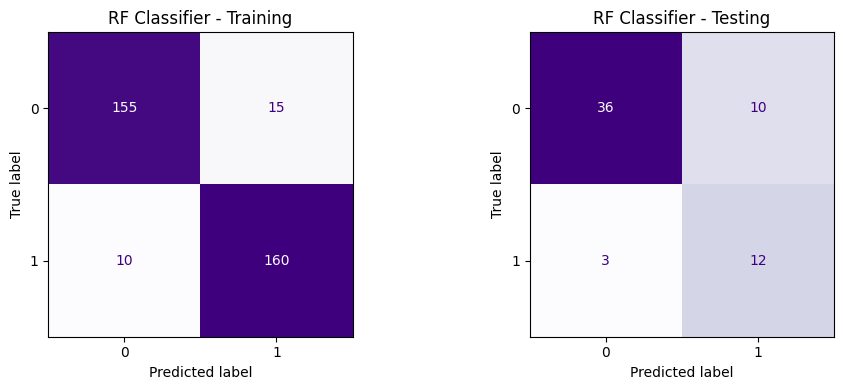

In [ ]:
matrix_train = confusion_matrix(y_balanced, train_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the training confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_train, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('RF Classifier - Training')

# Plotting the testing confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('RF Classifier - Testing')

plt.tight_layout()
plt.show()

# ***XGBoost (XGB)***

In [ ]:
param_random = {'n_estimators': [50, 80, 100],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.01, 0.02, 0.05],
                'subsample': [0.6, 0.7, 0.8]}

XGB_mdl = XGBClassifier()
XGB_randomcv = RandomizedSearchCV(XGB_mdl, param_random, n_iter=20, cv=5)
XGB_randomcv.fit(X_balanced, y_balanced)
XGB_param = XGB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(XGB_randomcv.best_score_))
print("Optimal parameters of XGB classifier: ", XGB_param)

#Training XGB model with optimal parameters
XGB_best_mdl = XGBClassifier(**XGB_param)
XGB_best_mdl.fit(X_balanced, y_balanced)

# Training performance
train_pred = XGB_best_mdl.predict(X_balanced)
training_acc = XGB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of XGB classifier: {training_acc:.4f}")
print("=== Training Report ===")
print(classification_report(y_balanced, train_pred))

# Testing performance
test_pred = XGB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

Best cross-validation score: 0.93
Optimal parameters of XGB classifier:  {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.02}
Training phase accuracy of XGB classifier: 0.9412
=== Training Report ===
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       170
           1       0.95      0.94      0.94       170

    accuracy                           0.94       340
   macro avg       0.94      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.92      0.78      0.85        46
           1       0.55      0.80      0.65        15

    accuracy                           0.79        61
   macro avg       0.73      0.79      0.75        61
weighted avg       0.83      0.79      0.80        61



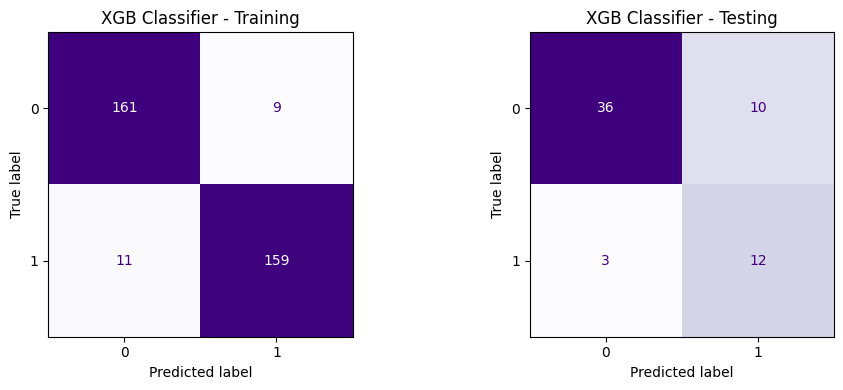

In [ ]:
matrix_train = confusion_matrix(y_balanced, train_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_train, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('XGB Classifier - Training')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('XGB Classifier - Testing')

plt.tight_layout()
plt.show()

# ***Gradient Boosting (GB)***

In [ ]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.005, 0.001, 0.015],
                'subsample': [0.6, 0.7, 0.8],
                'min_samples_split': [10, 12],
                'min_samples_leaf': [6, 8, 10]}

GB_mdl = GradientBoostingClassifier()
GB_randomcv = RandomizedSearchCV(GB_mdl, param_random, n_iter=20, cv=5)
GB_randomcv.fit(X_balanced, y_balanced)
GB_param = GB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(GB_randomcv.best_score_))
print("Optimal parameters of GB classifier: ", GB_param)

#Training GB model with optimal parameters
GB_best_mdl = GradientBoostingClassifier(**GB_param)
GB_best_mdl.fit(X_balanced, y_balanced)

# Training performance
train_pred = GB_best_mdl.predict(X_balanced)
training_acc = GB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of GB classifier: {training_acc:.4f}")
print("=== Training Report ===")
print(classification_report(y_balanced, train_pred))

# Testing performance
test_pred = GB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

Best cross-validation score: 0.93
Optimal parameters of GB classifier:  {'subsample': 0.6, 'n_estimators': 150, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_depth': 4, 'learning_rate': 0.015}
Training phase accuracy of GB classifier: 0.9412
=== Training Report ===
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       170
           1       0.94      0.94      0.94       170

    accuracy                           0.94       340
   macro avg       0.94      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        46
           1       0.57      0.80      0.67        15

    accuracy                           0.80        61
   macro avg       0.75      0.80      0.76        61
weighted avg       0.84      0.80      0.81        61



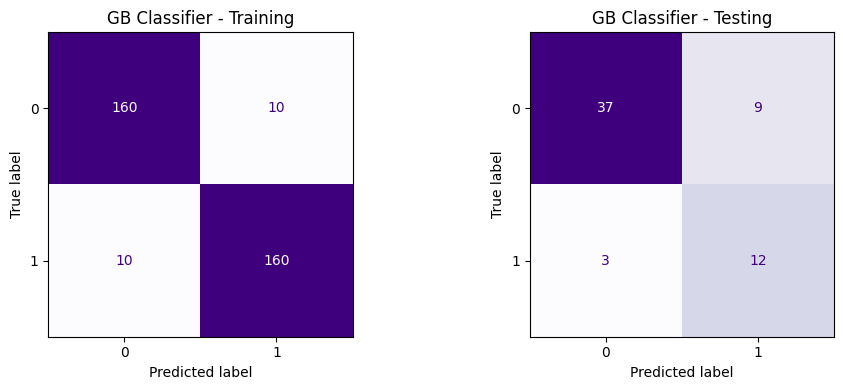

In [ ]:
matrix_train = confusion_matrix(y_balanced, train_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_train, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('GB Classifier - Training')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('GB Classifier - Testing')

plt.tight_layout()
plt.show()